In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt 
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import calendar
import xgboost as xgb
%matplotlib inline

In [2]:
train = pd.DataFrame.from_csv('./data/train.csv')

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance_manhattan(lon1, lat1, lon2, lat2):
    a = haversine_np(lon1, lat1, lon2, lat1)
    b = haversine_np(lon1, lat1, lon1, lat2)
    return a+b

def bearing_array(lon1, lat1, lon2, lat2):
    lon_delta_rad = np.radians(lon2 - lon1)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [4]:
train = train.reset_index()
train["year"] = pd.to_datetime(train['pickup_datetime']).dt.year
train["month"] = pd.to_datetime(train['pickup_datetime']).dt.month
train["day"] = pd.to_datetime(train['pickup_datetime']).dt.weekday
train["pickup_hour"] = pd.to_datetime(train['pickup_datetime']).dt.hour
train['pickup_minute'] = pd.to_datetime(train['pickup_datetime']).dt.minute
train['pickup_weekofyear'] = pd.to_datetime(train['pickup_datetime']).dt.weekofyear
train['pickup_date'] = pd.to_datetime(train['pickup_datetime']).dt.date

# Looping through arrays of data is very slow in python. 
# Numpy provides functions that operate on entire arrays of data, 
# which lets you avoid looping and drastically improve performance
train['distance'] = haversine_np(train['pickup_longitude'],
                                 train['pickup_latitude'],
                                 train['dropoff_longitude'],
                                 train['dropoff_latitude'])
train['distance_manhattan'] = distance_manhattan(train['pickup_longitude'],
                                                 train['pickup_latitude'],
                                                 train['dropoff_longitude'],
                                                 train['dropoff_latitude'])
train['bearing'] = bearing_array(train['pickup_longitude'],
                                 train['pickup_latitude'],
                                 train['dropoff_longitude'],
                                 train['dropoff_latitude'])
train["mean_speed"] = (train.distance / train.trip_duration)*3600
train['alone'] = (train['passenger_count']==1).apply(int)
train['center_latitude'] = (train['pickup_latitude'] + train['dropoff_latitude']) / 2
train['center_longitude'] = (train['pickup_longitude'] + train['dropoff_longitude']) / 2

### Distributions

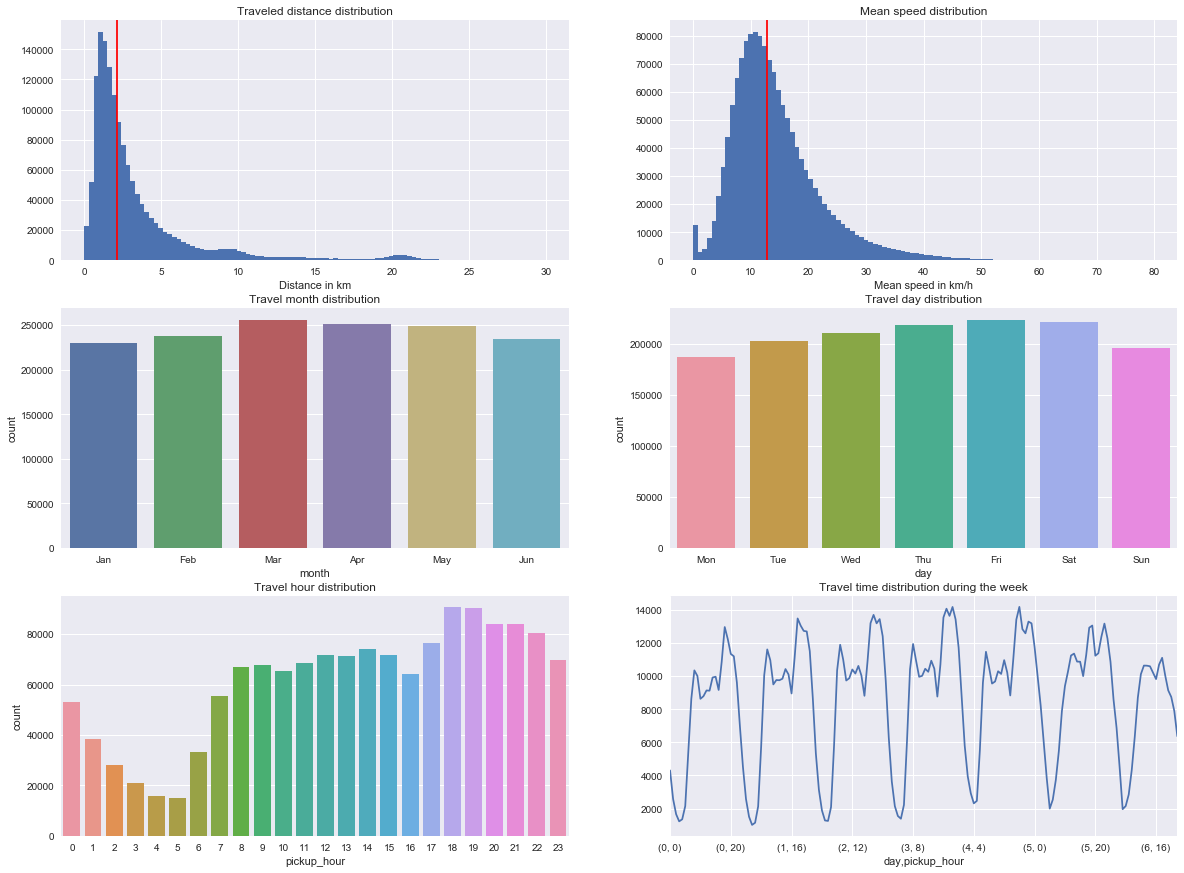

In [61]:
f, ax = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
train[train.distance < 30].distance.hist(bins=100, ax=ax[0,0])
ax[0, 0].axvline(train[train.distance < 30].distance.median(), color='red')
ax[0, 0].set_xlabel('Distance in km')
ax[0, 0].set_title('Traveled distance distribution')

train[train.mean_speed < 80].mean_speed.hist(bins=100, ax=ax[0,1])
ax[0, 1].axvline(train[train.mean_speed < 80].mean_speed.median(), color='red')
ax[0, 1].set_xlabel('Mean speed in km/h')
ax[0, 1].set_title('Mean speed distribution')

sns.countplot(train.month, ax =ax[1,0])
_ = ax[1,0].set_xticklabels([calendar.month_abbr[int(k.get_text())] for k in ax[1,0].get_xticklabels()])
ax[1, 0].set_title('Travel month distribution')

sns.countplot(train.day, ax =ax[1,1])
_ = ax[1,1].set_xticklabels([calendar.day_abbr[int(k.get_text())] for k in ax[1,1].get_xticklabels()])
ax[1, 1].set_title('Travel day distribution')

sns.countplot(train.pickup_hour, ax =ax[2,0])
ax[2, 0].set_title('Travel hour distribution')

train.groupby(['day', 'pickup_hour']).count()['vendor_id'].plot(ax=ax[2,1])
ax[2, 1].set_title('Travel time distribution during the week')

### Trip duration

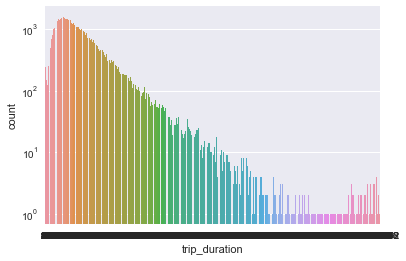

In [10]:
sns.countplot('trip_duration', data=train)
plt.yscale('log')

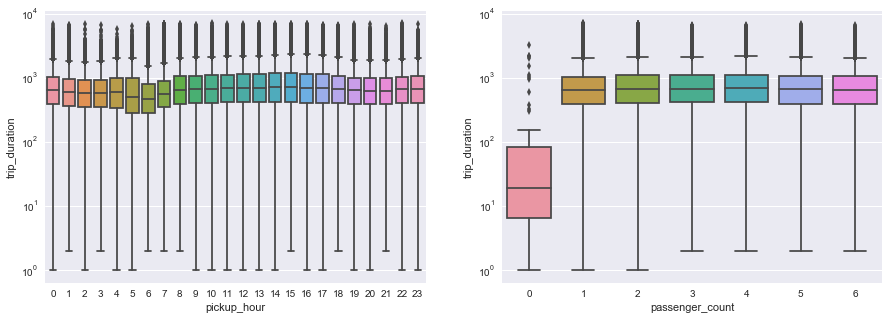

In [103]:
f, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(x='pickup_hour', y='trip_duration', data=train[train.trip_duration < 2*3600], ax = ax[0])
sns.boxplot(x='passenger_count', y='trip_duration', data=train[(train.trip_duration < 2*3600) & 
                                                               (train.passenger_count < 7)], ax = ax[1])
ax[1].set_yscale('log')
ax[0].set_yscale('log')

### Loneliness

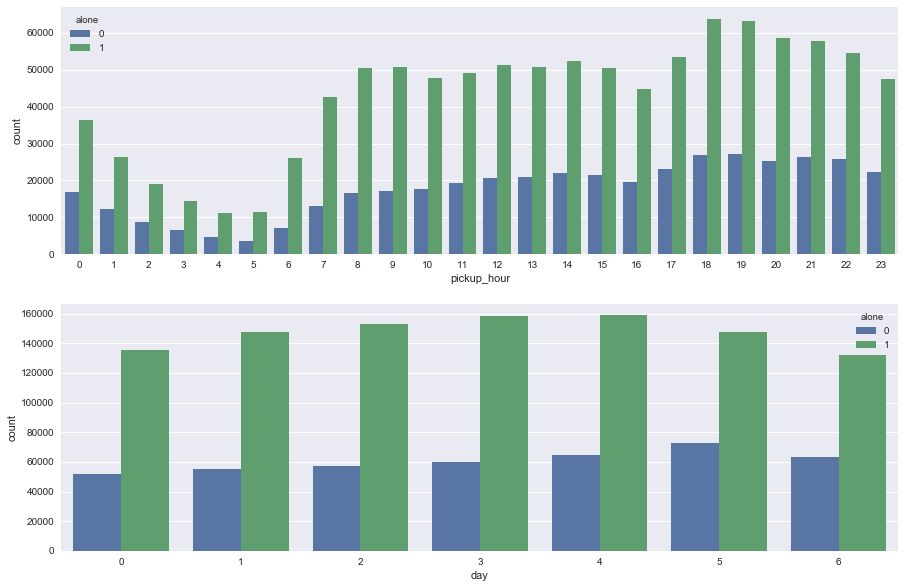

In [33]:
f, ax = plt.subplots(nrows=2, figsize=(15,10))
sns.countplot('pickup_hour', hue='alone', data=train, ax=ax[0])
sns.countplot('day', hue='alone', data=train, ax=ax[1])

People seems to travel lonely on week day and on the morning/evening, those taxi trips should be to go to work.  

### Vendor id

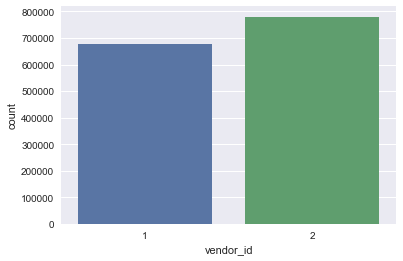

In [40]:
_ = sns.countplot('vendor_id', data=train)

There are more trip with vendor 2. Let's see, if the `vendor_id` has an influence on distributions.   
As there are more trips with vendor 2, if the vendor has no influence, distribution should be a little more important for vendor 2.

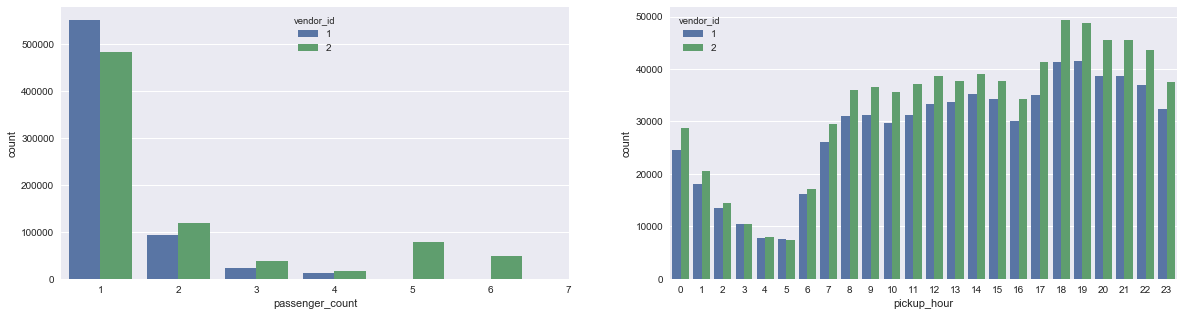

In [44]:
f, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.countplot("passenger_count", hue='vendor_id', data=train, ax =ax[0])
_ = ax[0].set_xlim([0.5, 7])

sns.countplot("pickup_hour", hue='vendor_id', data=train, ax =ax[1])

1. As you can see,  almost all the big cars (>= 5 passengers) belong to vendor 2. Vendor 2 should have a bigger car.  
While vendor seems busy with trip with many passengers, vendor 1 take more lonely passengers.
  
2. The passenger count doesn't seem to influence the pick up hour. Altough, people are more traveling with vendor 1 in proportion in the night (3-6am).


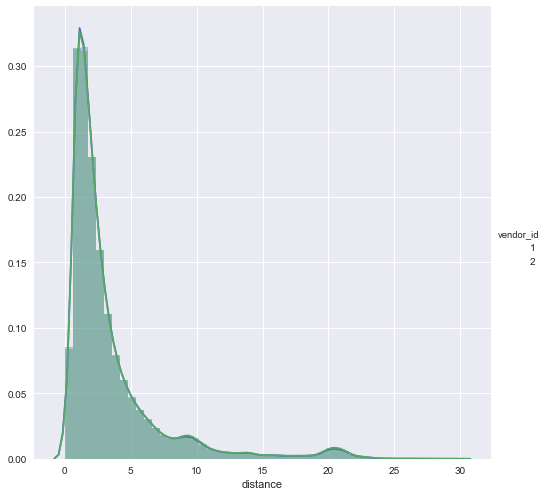

In [92]:
g =sns.FacetGrid(train[train.distance < 30], hue="vendor_id", size=7)
g = g.map(sns.distplot, "distance")
g.add_legend({'green': 'vendor 1', 'blue':"vendor 2"})

No influence of the `vendor id` on the traveled distance

### Traffic

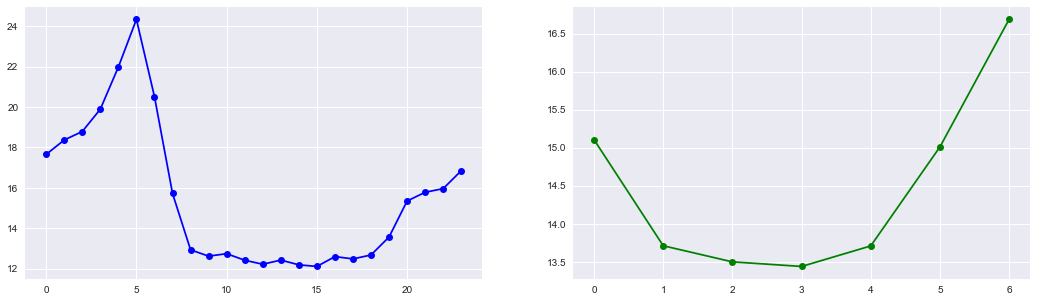

In [47]:
f, ax = plt.subplots(ncols=2, figsize=(18,5))
ax[0].plot(train.groupby('pickup_hour').mean()['mean_speed'], 'bo-')
ax[1].plot(train.groupby('day').mean()['mean_speed'], 'go-')

As we can see, traffic is more important during the day (8-19) and the week day (Monday-Friday).

### Cleaning extreme trips

In [17]:
for k in [0.5, 1, 5, 10, 20, 100]:
    print("{} hours+ trips : {:.4f} %".format(k, (len(train[train.trip_duration > k * 3600]) / len(train))*100))

0.5hours+ trips : 7.7550 %
1hours+ trips : 0.8444 %
5hours+ trips : 0.1420 %
10hours+ trips : 0.1379 %
20hours+ trips : 0.1325 %
100hours+ trips : 0.0003 %


99% of the trips are less than one hour.

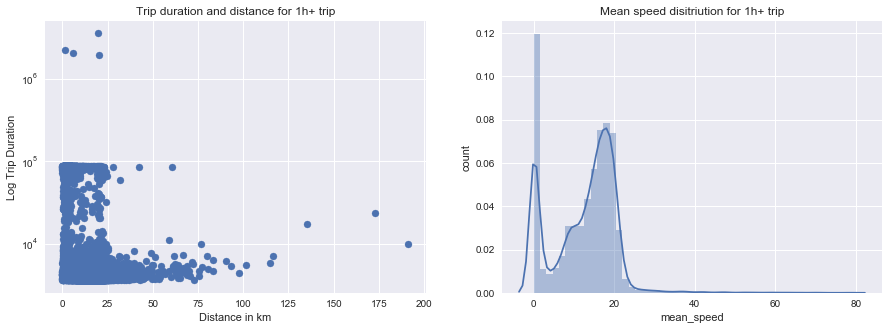

In [28]:
extreme = train[train.trip_duration > 3600]
f, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].scatter(extreme.distance, extreme.trip_duration)
ax[0].set_yscale('log')
ax[0].set_ylabel('Log Trip Duration')
ax[0].set_xlabel('Distance in km')
ax[0].set_title('Trip duration and distance for 1h+ trip')

sns.distplot(extreme['mean_speed'], ax=ax[1])
ax[1].set_ylabel('count')
ax[1].set_title('Mean speed disitriution for 1h+ trip')

There are some odd long (>1h) trips with a mean speed closed to 0 km/h and some trips with a distance closed to 0 km but with a trip duration > 1h ...

In [32]:
print('The mean trip duration for 1h+ trip with a speed < 1 km/h is {:.2f} hour'.format(extreme[extreme.mean_speed < 1].trip_duration.mean()/3600))

The mean trip duration for 1h+ trip with a speed < 1 km/h is 22.43 hour


For ~1 day trip seems unreal and they need to be removed. So, i will remove 20h+ trips (<0.15% of the database).

### PCA

In [5]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
for k in range(2):
    train['pickup_pca%s' % k] = pca.transform(train[['pickup_latitude', 
                                                     'pickup_longitude']])[:, k]
    train['dropoff_pca%s' % k] = pca.transform(train[['dropoff_latitude',                                                    'dropoff_longitude']])[:, k]

In [6]:
train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) +\
                                np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

### Clustering

In [7]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [8]:
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

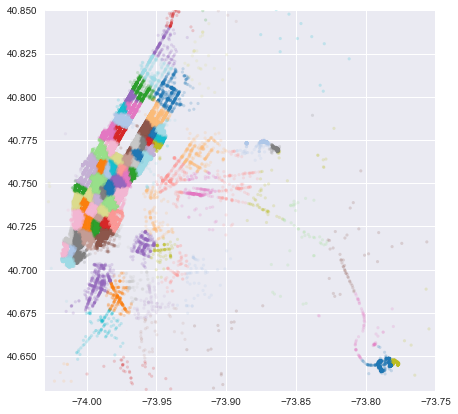

In [27]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(7,7))
plt.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
_ = plt.xlim(city_long_border)
_ = plt.ylim(city_lat_border)

In [9]:
# Time aggregation for each cluster
for gby_col in ['pickup_hour', 'pickup_date', 
                'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['mean_speed', 'trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['mean_speed']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['mean_speed_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)

In [25]:
train['trip_over_1h'] = (train.trip_duration > 3600).apply(int)
for t in ['pickup', 'dropoff']:
    k = train.groupby('%s_cluster' % t ).sum()[['trip_over_1h']].reset_index()
    k.columns = ['%s_cluster' % t, '%s_cluster_trip_over_1h' %t]
    train = pd.merge(train, k, on = '%s_cluster' % t)


### Feature importance

In [113]:
df = train[train.trip_duration < 5*3600]

In [ ]:
do_not_use_for_training = ['id', 'trip_duration', 'pickup_datetime', 'dropoff_datetime', 
                           'mean_speed','year']

In [27]:
## Do same thing for test !!

In [114]:
y = df.trip_duration
X = df.drop(['pickup_datetime', 'dropoff_datetime', 
             'trip_duration', 'year', 'mean_speed'], axis=1)

In [115]:
le = LabelEncoder()
X.store_and_fwd_flag = le.fit_transform(X.store_and_fwd_flag)

In [107]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [116]:
clf = RandomForestRegressor(oob_score=True)
clf.fit(X, y)

/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [117]:
clf.oob_score_

0.68597901754317425

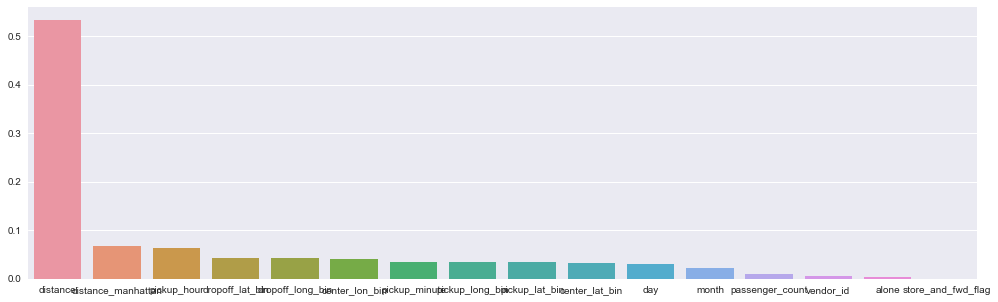

In [89]:
plt.figure(figsize=(17,5))
sns.barplot(X.columns[np.argsort(clf.feature_importances_)[::-1]], np.sort(clf.feature_importances_)[::-1])

### Prediction

In [118]:
test = pd.DataFrame.from_csv('./data/test.csv')
test["month"] = pd.to_datetime(test['pickup_datetime']).dt.month
test["day"] = pd.to_datetime(test['pickup_datetime']).dt.weekday
test["pickup_hour"] = pd.to_datetime(test['pickup_datetime']).dt.hour
test['pickup_minute'] = pd.to_datetime(test['pickup_datetime']).dt.minute

test['distance'] = haversine_np(test['pickup_longitude'],
                                 test['pickup_latitude'],
                                 test['dropoff_longitude'],
                                 test['dropoff_latitude'])

test['distance_manhattan'] = distance_manhattan(test['pickup_longitude'],
                                                test['pickup_latitude'],
                                                test['dropoff_longitude'],
                                                test['dropoff_latitude'])

test['alone'] = (test['passenger_count']==1).apply(int)

test = test.drop(['pickup_datetime'], axis=1)
test.store_and_fwd_flag = le.transform(test.store_and_fwd_flag)

In [119]:
test['trip_duration'] = clf.predict(test).apply(lambda x:round(x))

In [120]:
test.reset_index()[['id','trip_duration']].to_csv('submission2.csv', index=False)